# Research question
Which Community Districts in NYC show the highest number of complaints?

In [4]:
import os
import pandas as pd
import numpy as np
import re
import matplotlib.pylab as pl
import getcsv
%matplotlib inline
PUIdata = os.getenv('PUIDATA')

In [2]:
getcsv.getCSV()

file in place, you can continue


In [5]:
data = pd.read_csv(PUIdata + "/erm2-nwe9", 
                   usecols=['Complaint Type', 'Descriptor', 'Borough', 'Created Date',
                            'Resolution Description', 'Community Board'])

In [63]:
data.head()

,Created Date,Complaint Type,Descriptor,Resolution Description,Community Board,Borough,Community Index,Community Borough
0,11/05/2015 02:59:15 AM,Street Condition,Pothole,NaN,13 BROOKLYN,BROOKLYN,13.0,BROOKLYN
2,11/05/2015 02:06:51 AM,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,18 BROOKLYN,BROOKLYN,18.0,BROOKLYN
3,11/05/2015 02:02:20 AM,Illegal Parking,Blocked Hydrant,Your complaint has been received by the Police...,12 BROOKLYN,BROOKLYN,12.0,BROOKLYN
5,11/05/2015 01:55:55 AM,Highway Condition,Pothole - Highway,The Department of Transportation requires 10 d...,02 STATEN ISLAND,STATEN ISLAND,2.0,STATEN
7,11/05/2015 01:47:12 AM,Noise - Commercial,Loud Music/Party,Your complaint has been forwarded to the New Y...,08 MANHATTAN,MANHATTAN,8.0,MANHATTAN


# 3. Think about possible measurement errors
Do you see any problems regarding possible measurement error? Think about who is represented in the data, ommissions, duplications, content error, missing data, etc. 

In [7]:
# Check if all Boroughs and Community Districts are represented in the Data 
data.Borough.unique()

array(['BROOKLYN', 'Unspecified', 'STATEN ISLAND', 'MANHATTAN', 'BRONX',
       'QUEENS'], dtype=object)

In [8]:
print (data['Community Board'].unique())

['13 BROOKLYN' '0 Unspecified' '18 BROOKLYN' '12 BROOKLYN'
 '02 STATEN ISLAND' '08 MANHATTAN' '06 BROOKLYN' '10 BRONX' '06 MANHATTAN'
 '04 BROOKLYN' '04 QUEENS' '09 MANHATTAN' '14 BROOKLYN' '05 MANHATTAN'
 '02 MANHATTAN' '10 QUEENS' '07 QUEENS' '02 QUEENS' '11 BROOKLYN'
 '05 QUEENS' '05 BROOKLYN' '09 QUEENS' '12 MANHATTAN' '01 BROOKLYN'
 '11 MANHATTAN' '03 BRONX' '03 STATEN ISLAND' '08 BROOKLYN' '03 BROOKLYN'
 '07 MANHATTAN' '10 MANHATTAN' '04 BRONX' '01 MANHATTAN' '07 BRONX'
 '09 BRONX' '03 MANHATTAN' '13 QUEENS' '02 BRONX' '12 QUEENS' '16 BROOKLYN'
 '08 QUEENS' '04 MANHATTAN' '14 QUEENS' '10 BROOKLYN' '11 QUEENS'
 '06 BRONX' '08 BRONX' '05 BRONX' '15 BROOKLYN' '02 BROOKLYN' '12 BRONX'
 '03 QUEENS' '06 QUEENS' '01 STATEN ISLAND' '01 BRONX' '01 QUEENS'
 '17 BROOKLYN' '11 BRONX' 'Unspecified QUEENS' '09 BROOKLYN'
 'Unspecified MANHATTAN' 'Unspecified BROOKLYN' '07 BROOKLYN'
 'Unspecified BRONX' '64 MANHATTAN' '81 QUEENS' '55 BROOKLYN' '83 QUEENS'
 'Unspecified STATEN ISLAND' '28 BRONX' 

In [12]:
# How many unique values do we have?
print ("No. of unique Community Districts -", len(data['Community Board'].unique()))
print ("No. of unique complaint types -", len(data['Complaint Type'].unique()))
print ("No. of unique complaint descriptors -",len(data['Descriptor'].unique()))

No. of unique Community Districts - 77
No. of unique complaint types - 242
No. of unique complaint descriptors - 1629


### There are many unique entries, some of them are unspecified, missing. Some might be invalid entries. 
### We should have 59 Community Districts, there are some unspecified entries

In [13]:
# Check for duplicates? Are these plausible?
data.duplicated(subset = ('Created Date', 'Complaint Type', 'Descriptor', 'Community Board')).sum()

2719422

In [14]:
# What about missing values? Can you detect any patterns? 
data.head(3)

,Created Date,Complaint Type,Descriptor,Resolution Description,Community Board,Borough
0,11/05/2015 02:59:15 AM,Street Condition,Pothole,NaN,13 BROOKLYN,BROOKLYN
1,11/05/2015 02:09:49 AM,Opinion for the Mayor,HOUSING,Your comments have been submitted to the Mayor...,0 Unspecified,Unspecified
2,11/05/2015 02:06:51 AM,Root/Sewer/Sidewalk Condition,Trees and Sidewalks Program,The Department of Parks and Recreation usually...,18 BROOKLYN,BROOKLYN


### After looking at the data, missing values are present for entries with Unspecified Community Boards, some of the unspecified entries of Community boards can be corrected with the street address, latitude and longitude or zip. Other entries which I think cannot be recovered can be ignored as they are less than 5%

In [15]:
len(data['Resolution Description'].unique())

1029

In [16]:
data1 = data.loc[:,['Complaint Type', 'Resolution Description']]

In [17]:
data1.drop_duplicates(subset = ['Resolution Description'], inplace = True)

In [20]:
data1[data1['Complaint Type'] == 'Street Condition'].head()

,Complaint Type,Resolution Description
0,Street Condition,NaN
290,Street Condition,The Department of Transportation requires 30 d...
340,Street Condition,The Department of Transportation requires 90 d...
1884,Street Condition,The Department of Transportation will inspect ...
2241,Street Condition,The agency has investigated this request and f...


### Data Editing: Is it possible to replace missing values? Is it possible to use Complaint Type to fill missings in Resolution Descriptor?
### The missing values can be replaced, however, our focus is on the number of complaints per community districts. Hence the missing values in Descriptor can be ignored.

## Generate marker for unplausible Community Districts
## How do these districts look like? 

### The unplausible districts are either unspecified or their community index is wrong. 

In [21]:
data['Community Index'] = data['Community Board'].str.extract('(\d+)', expand=True)
data['Community Borough'] = data['Community Board'].str.extract('([A-Z]\w{0,})', expand=True)

data['Community Index'] = pd.to_numeric(data['Community Index'], errors='coerce')

In [22]:
# Drop the marked districts
cd_manhattan =(data['Community Index'] > 0) & (data['Community Index'] < 13) \
& (data['Community Borough'] == 'MANHATTAN')

cd_brooklyn = (data['Community Index'] > 0) & (data['Community Index'] < 19) \
& (data['Community Borough'] == 'BROOKLYN')

cd_queens = (data['Community Index'] > 0) & (data['Community Index'] < 15) \
& (data['Community Borough'] == 'QUEENS')

cd_statenisland = (data['Community Index'] > 0) & (data['Community Index'] < 4) \
& (data['Community Borough'] == 'STATEN')

cd_bronx = (data['Community Index'] > 0) & (data['Community Index'] < 13) \
& (data['Community Borough'] == 'BRONX')

cd_total = cd_manhattan | cd_brooklyn | cd_queens | cd_statenisland | cd_bronx

data = data[cd_total]

In [23]:
len(data['Community Board'].unique())

59

In [24]:
# Produce your result: Generate an indicator which ranks the Community District by complaint numbers 
# on the Community district level

complaints = data.groupby('Community Board').count()

complaints.drop(['Created Date', 'Resolution Description', 'Descriptor',
                 'Borough', 'Community Borough', 'Community Index'], axis = 1, inplace = True)
complaints['Complaints_Rank'] = complaints['Complaint Type'].rank(ascending=False)

complaints.reset_index(inplace=True)
complaints.rename(columns={'Complaint Type' : 'Complaint Count'}, inplace=True)

In [25]:
# Save reduced data frame (Community District level)
complaints.head()

,Community Board,Complaint Count,Complaints_Rank
0,01 BRONX,74631,57.0
1,01 BROOKLYN,185057,9.0
2,01 MANHATTAN,77974,55.0
3,01 QUEENS,171484,12.0
4,01 STATEN ISLAND,182713,10.0


# 4. Think about the interpretation of your results?
What do you have to keep in mind when interpreting your results? Are they generable? Does the way the data is collected influence your results? To better inform city agancies it might be good to explore in more detail the underlying dempgraphics/infrastructure of a Community District becasue this might influence 311 calls. You can do this by merging external data on the Community District level to your analysis data. 

In [26]:
# Population by Community District
df_pop = pd.read_csv("http://cosmo.nyu.edu/~fb55/PUI2016/data/Final_Demographics.csv")
df_pop.head()

,FIPS,cd_id,Total Population,Population Density (per sq. mile),% Total Population: Male,% Total Population: 18 to 24 Years,% Total Population: 25 to 34 Years,% Total Population: 35 to 44 Years,% Population 5 Years And Over: Speak Only English,% Population 5 Years And Over: Spanish or Spanish Creole,...,"Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Production occupations","Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Transportation and material moving occupations","% Employed Civilian Population 16 Years And Over: Management, professional, and related occupations",% Employed Civilian Population 16 Years And Over: Service occupations,% Employed Civilian Population 16 Years And Over: Sales and office occupations,"% Employed Civilian Population 16 Years And Over: Farming, fishing, and forestry occupations","% Employed Civilian Population 16 Years And Over: Construction, extraction, and maintenance occupations","% Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations","% Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Production occupations","% Employed Civilian Population 16 Years And Over: Production, transportation, and material moving occupations: Transportation and material moving occupations"
0,3603701,BX08,106737,31229.95006,46.65,10.73,15.04,11.32,46.80,39.24,...,665,1518,42.66,28.95,20.89,0.24,2.65,4.60,1.40,3.20
1,3603702,BX12,134644,19966.67839,46.35,11.35,14.29,12.57,73.09,18.19,...,1156,4174,29.57,33.98,20.40,0.00,7.08,8.97,1.95,7.02
2,3603703,BX10,121209,12913.81703,45.20,8.62,13.74,12.78,61.79,26.43,...,941,3433,36.20,22.85,25.09,0.00,7.68,8.18,1.76,6.42
3,3603704,BX11,135839,35677.95453,50.09,8.10,17.43,14.09,43.22,36.45,...,2189,5592,30.06,27.86,22.24,0.00,7.03,12.81,3.60,9.20
4,3603705,BX03,172247,39405.79222,44.72,14.24,14.89,12.38,36.82,54.24,...,1437,5436,16.80,41.00,22.29,0.03,8.45,11.43,2.39,9.04


In [27]:
# Check variables in file
print("There are %d variables in the file"%len(df_pop.columns))

There are 158 variables in the file


In [28]:
# How many community districts are in file? 
print("There are %d community districts in the file"%len(df_pop.cd_id.unique()))

There are 59 community districts in the file


In [35]:
# Manipulate data to get some information on demographics by Community District. 
# Think about who might be more likely to call 311
demographics = df_pop[['FIPS','cd_id','Median household income (In 2014 Inflation Adjusted Dollars)']]

#### I have taken Median income as an indicator of demographics. 
#### My assumption is that districts where median income is higher should have higher number of 311 calls.

#### Replacing the errornous entry of MN1111 by MN11

In [36]:
demographics[demographics['cd_id'] == 'MN11111']

,FIPS,cd_id,Median household income (In 2014 Inflation Adjusted Dollars)
15,3603804,MN11111,31340


In [37]:
demographics.loc[demographics[demographics['cd_id'] == 'MN11111'].index, 'cd_id'] = 'MN11'

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [38]:
demographics.drop(['FIPS'],axis= 1, inplace= True)
demographics.head()

/opt/rh/anaconda/root/envs/PUI2016_Python3/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,cd_id,Median household income (In 2014 Inflation Adjusted Dollars)
0,BX08,54224
1,BX12,44906
2,BX10,54962
3,BX11,47910
4,BX03,22041


In [40]:
# Infrastructure by Community District
df_infr = pd.read_csv("http://cosmo.nyu.edu/~fb55/PUI2016/data/ACS_Computer_Use_and_Internet_2014_1Year_Estimate.csv")
print (df_infr.dtypes)
df_infr.head()

FIPS                                                         int64
Geographic Identifier                                       object
Qualifying Name                                             object
Households                                                   int64
Households: With An Internet Subscription                    int64
Households: Dial-Up Alone                                    int64
Households: Dsl                                              int64
Households: With Mobile Broadband                            int64
Households: Without Mobile Broadband                         int64
Households: Cable Modem                                      int64
Households: With Mobile Broadband.1                          int64
Households: Without Mobile Broadband.1                       int64
Households: Fiber-Optic                                      int64
Households: With Mobile Broadband.2                          int64
Households: Without Mobile Broadband.2                       i

,FIPS,Geographic Identifier,Qualifying Name,Households,Households: With An Internet Subscription,Households: Dial-Up Alone,Households: Dsl,Households: With Mobile Broadband,Households: Without Mobile Broadband,Households: Cable Modem,...,Households: Mobile Broadband Alone or With Dialup,Households: Internet Access Without A Subscription,Households: No Internet Access,% Households: With An Internet Subscription,Households.1,Households: Has A Computer,Households: With Dial-Up Internet Subscription Alone,Households: With A Broadband Internet Subscription,Households: Without An Internet Subscription,Households: No Computer
0,3603701,79500US3603701,"NYC-Bronx Community District 8--Riverdale, New...",42035,31795,444,2813,946,1867,19178,...,2168,2119,8121,75.64,42035,35048,404,30943,3701,6987
1,3603702,79500US3603702,"NYC-Bronx Community District 12--Wakefield, Ne...",44830,32243,178,849,405,444,18653,...,928,1891,10696,71.92,44830,36700,178,31435,5087,8130
2,3603703,79500US3603703,"NYC-Bronx Community District 10--Co-op City, N...",47050,32729,158,1863,398,1465,20044,...,639,2882,11439,69.56,47050,38700,158,32333,6209,8350
3,3603704,79500US3603704,NYC-Bronx Community District 11--Pelham Parkwa...,44922,32003,141,1478,474,1004,17917,...,1001,2722,10197,71.24,44922,37237,122,31278,5837,7685
4,3603705,79500US3603705,"NYC-Bronx Community District 3 & 6--Belmont, N...",57556,35503,88,1297,651,646,15847,...,1385,3312,18741,61.68,57556,42576,88,33408,9080,14980


In [41]:
# Check variables in file
print("There are %d variables in the file"%len(df_infr.columns))

There are 31 variables in the file


In [42]:
# How many community districts are in file? 
print("There are %d community districts in the file"%len(df_infr['Qualifying Name'].unique()))

There are 55 community districts in the file


In [43]:
# Manipulate data to get some information on internet/broadband useage by Community District
# Aggregate the mobile subscription data
internet = pd.DataFrame(df_infr['Qualifying Name'])
internet.loc[:,'Total Mobile Subscription'] = df_infr['Households: With Mobile Broadband'] + \
df_infr['Households: With Mobile Broadband.1'] + df_infr['Households: With Mobile Broadband.2'] + \
df_infr['Households: With Mobile Broadband.3'] + df_infr['Households: With Mobile Broadband.4'] 
internet.head()

,Qualifying Name,Total Mobile Subscription
0,"NYC-Bronx Community District 8--Riverdale, New...",15359
1,"NYC-Bronx Community District 12--Wakefield, Ne...",10486
2,"NYC-Bronx Community District 10--Co-op City, N...",11425
3,NYC-Bronx Community District 11--Pelham Parkwa...,10748
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",14907


In [44]:
# Aggregate internet type by high and low connections
internet.loc[:,'% Households: With An Internet Subscription'] = df_infr["% Households: With An Internet Subscription"]
internet.head()

,Qualifying Name,Total Mobile Subscription,% Households: With An Internet Subscription
0,"NYC-Bronx Community District 8--Riverdale, New...",15359,75.64
1,"NYC-Bronx Community District 12--Wakefield, Ne...",10486,71.92
2,"NYC-Bronx Community District 10--Co-op City, N...",11425,69.56
3,NYC-Bronx Community District 11--Pelham Parkwa...,10748,71.24
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",14907,61.68


# 5. Inform your results by linking datasets
Now you want to link the three data frames to produce summary statistics for Community Districts which show a high number of complaints vs. Community Districts which show a lower number of complaints. Please keep in mind that the identifiers used for the linkage (Community Dostrict IDs) should be recored the same way. Use regular expressions to harmonize the identifiers if possible. The identifiers should look like BK01, BK02, etc.
https://docs.python.org/2/library/re.html

In [45]:
# Harmonize identifier of dataframe 1
complaints['Community Index'] = complaints['Community Board'].str.extract('(\d+)', expand=True)
complaints['Community Borough'] = complaints['Community Board'].str.extract('([A-Z]\w{0,})', expand=True)

complaints['Abbr'] = complaints['Community Borough']
complaints['Abbr'] = complaints['Abbr'].str.replace(pat='BROOKLYN', repl='BK')
complaints['Abbr'] = complaints['Abbr'].str.replace(pat='MANHATTAN', repl='MN')
complaints['Abbr'] = complaints['Abbr'].str.replace(pat='STATEN', repl='SI')
complaints['Abbr'] = complaints['Abbr'].str.replace(pat='BRONX', repl='BX')
complaints['Abbr'] = complaints['Abbr'].str.replace(pat='QUEENS', repl='QN')
complaints['cd_id'] = complaints[['Abbr', 'Community Index']].apply(lambda x: ''.join(x), axis = 1)
complaints.drop(['Community Index', 'Abbr','Community Borough'], axis=1, inplace=True)
complaints.head()

,Community Board,Complaint Count,Complaints_Rank,cd_id
0,01 BRONX,74631,57.0,BX01
1,01 BROOKLYN,185057,9.0,BK01
2,01 MANHATTAN,77974,55.0,MN01
3,01 QUEENS,171484,12.0,QN01
4,01 STATEN ISLAND,182713,10.0,SI01


In [46]:
# Harmonize identifier of dataframe 2
demographics.head()

,cd_id,Median household income (In 2014 Inflation Adjusted Dollars)
0,BX08,54224
1,BX12,44906
2,BX10,54962
3,BX11,47910
4,BX03,22041


In [47]:
# Harmonize identifier of dataframe 3
internet.head()

,Qualifying Name,Total Mobile Subscription,% Households: With An Internet Subscription
0,"NYC-Bronx Community District 8--Riverdale, New...",15359,75.64
1,"NYC-Bronx Community District 12--Wakefield, Ne...",10486,71.92
2,"NYC-Bronx Community District 10--Co-op City, N...",11425,69.56
3,NYC-Bronx Community District 11--Pelham Parkwa...,10748,71.24
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",14907,61.68


In [48]:
# Extracting the Community Borough and community index from the Qualifying Name column
internet['Borough'] = internet['Qualifying Name'].str.extract('NYC-(\w+)\W', expand=True)
internet['Community Index 1'] = internet['Qualifying Name'].str.extract('(\d+)', expand=True)
internet['Community Index 2'] = internet['Qualifying Name'].str.extract('(\d+\W+\d+)', expand=True)
internet['Community Index 3'] = internet['Qualifying Name'].str.extract('(\d+)(?!.*\d)', expand = True)

In [49]:
internet.loc[:,'Abbr'] = internet['Borough']
internet.loc[:,'Abbr'] = internet['Abbr'].str.replace(pat='Brooklyn', repl='BK')
internet.loc[:,'Abbr'] = internet['Abbr'].str.replace(pat='Manhattan', repl='MN')
internet.loc[:,'Abbr'] = internet['Abbr'].str.replace(pat='Staten', repl='SI')
internet.loc[:,'Abbr'] = internet['Abbr'].str.replace(pat='Bronx', repl='BX')
internet.loc[:,'Abbr'] = internet['Abbr'].str.replace(pat='Queens', repl='QN')

In [50]:
internet['Community Index 2'] = internet['Community Index 2'].fillna(0)

In [51]:
#Some Qualifying Name entries have community index as 01&02, 03&06, splitting such entries
flag = 0
for i in range(len(internet)):
    if (flag == 1):
        internet.loc[i,'Community Index 1'] = internet.loc[i,'Community Index 3']
        flag = 0
    if (internet['Community Index 2'][i] != 0):
        flag = 1

In [52]:
internet['Community Index 1'] = internet['Community Index 1'].apply(lambda x: x.zfill(2))

In [53]:
internet['cd_id'] = internet[['Abbr', 'Community Index 1']].apply(lambda x: ''.join(x), axis = 1)
internet.head()

,Qualifying Name,Total Mobile Subscription,% Households: With An Internet Subscription,Borough,Community Index 1,Community Index 2,Community Index 3,Abbr,cd_id
0,"NYC-Bronx Community District 8--Riverdale, New...",15359,75.64,Bronx,08,0,8,BX,BX08
1,"NYC-Bronx Community District 12--Wakefield, Ne...",10486,71.92,Bronx,12,0,12,BX,BX12
2,"NYC-Bronx Community District 10--Co-op City, N...",11425,69.56,Bronx,10,0,10,BX,BX10
3,NYC-Bronx Community District 11--Pelham Parkwa...,10748,71.24,Bronx,11,0,11,BX,BX11
4,"NYC-Bronx Community District 3 & 6--Belmont, N...",14907,61.68,Bronx,03,3 & 6,6,BX,BX03


In [54]:
internet.drop(['Qualifying Name', 'Borough', 'Community Index 1', 'Community Index 2', 'Community Index 3', 'Abbr'],\
              axis = 1, inplace=True)
internet.head()

,Total Mobile Subscription,% Households: With An Internet Subscription,cd_id
0,15359,75.64,BX08
1,10486,71.92,BX12
2,11425,69.56,BX10
3,10748,71.24,BX11
4,14907,61.68,BX03


In [55]:
# Link the 3 dataframes
complaints_linked = pd.merge(complaints, demographics, on='cd_id', how = 'outer')
complaints_linked = pd.merge(complaints_linked, internet, on='cd_id', how = 'outer')

In [57]:
complaints_linked.sort_values('Complaints_Rank').head()

,Community Board,Complaint Count,Complaints_Rank,cd_id,Median household income (In 2014 Inflation Adjusted Dollars),Total Mobile Subscription,% Households: With An Internet Subscription
49,12 MANHATTAN,268053,1.0,MN12,45157,22019,75.57
50,12 QUEENS,229383,2.0,QN12,52537,9148,71.94
11,03 BROOKLYN,197306,3.0,BK03,34678,8436,65.97
30,07 QUEENS,195961,4.0,QN07,52105,21980,76.73
57,17 BROOKLYN,191720,5.0,BK17,42349,12700,70.35


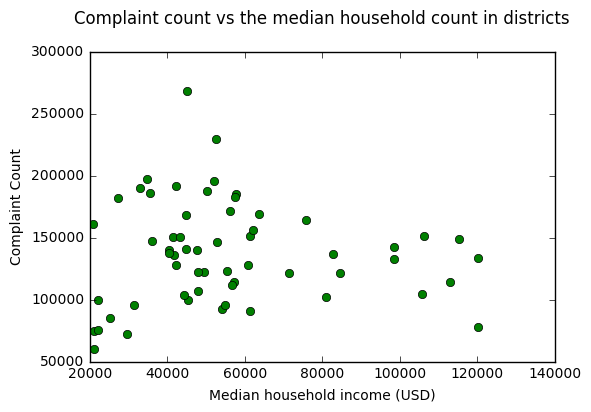

In [64]:
# Are the demographics and infrastructure different in Community Districts that show more complaints than others?
pl.plot(complaints_linked['Median household income (In 2014 Inflation Adjusted Dollars)'], \
        complaints_linked['Complaint Count'], 'o', c='g')
pl.xlabel('Median household income (USD)')
pl.ylabel('Complaint Count')
pl.title('Complaint count vs the median household count in districts\n')
pl.show()

### Figure 1: Community districts with low income are less likely to make 311 calls. Community districts with a median income of more than 40,000 USD make more calls.

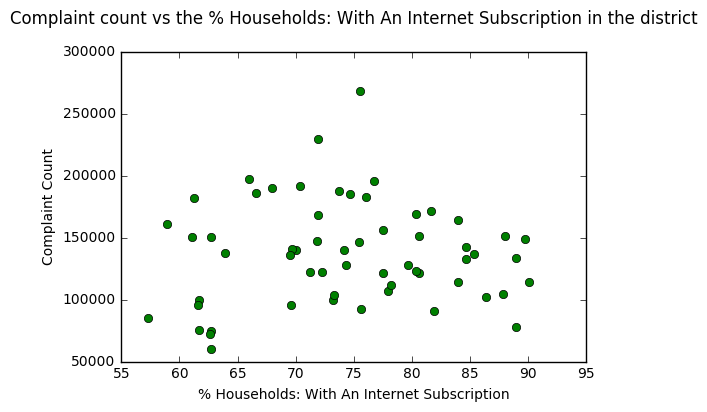

In [61]:
pl.plot(complaints_linked['% Households: With An Internet Subscription'], \
        complaints_linked['Complaint Count'], 'o', c='g')

pl.ylabel('Complaint Count')
pl.xlabel('% Households: With An Internet Subscription')
pl.title('Complaint count vs the \
% Households: With An Internet Subscription in the district\n')
pl.show()

### Figure 2: Community districts with higher infrastructure and ones with higher internet subscribtion are more likely to make 311 calls.

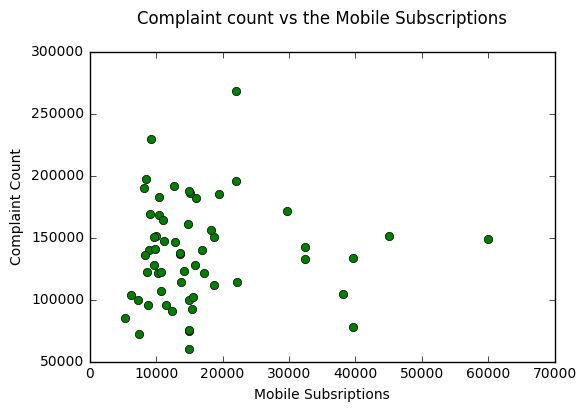

In [62]:
pl.plot(complaints_linked['Total Mobile Subscription'], \
        complaints_linked['Complaint Count'], 'o', c='g')

pl.ylabel('Complaint Count')
pl.xlabel('Mobile Subsriptions')
pl.title('Complaint count vs the \
Mobile Subscriptions\n')
pl.show()

### Figure 3: Community districts with higher infrastructure and with higher mobile customers are more likely to make 311 calls. In above figure, where mobile customers are gretaer than 10000, the number of complaints is higher for most districts.